<a href="https://colab.research.google.com/github/rider110/Basic/blob/main/CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wandb

In [2]:
import os
import sys
import glob
import math
import cv2
import random
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as T
from torchvision.models.feature_extraction import create_feature_extractor


In [ ]:
# Log in to your W&B account
import wandb
wandb.login()

wandb.init(
        project="CIFAR-10",
        config={
            #"model": resnet34,
            "epochs": 5,
            "batch_size": 32,
            "lr": 1e-3,
            "dropout": random.uniform(0.01, 0.80),
            "num_workers": 2,
            })

config = wandb.config

In [ ]:
transform = T.Compose(
    [T.ColorJitter(brightness = 0.8, contrast=0.3, saturation=0.5),
     T.ToTensor(),
     T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=config.batch_size,
                                          shuffle=True, num_workers=config.num_workers)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=config.batch_size,
                                         shuffle=False, num_workers=config.num_workers)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

n_steps_per_epoch = math.ceil(len(trainloader.dataset) / config.batch_size)


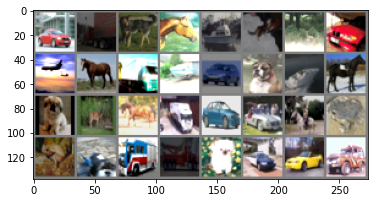

car   truck dog   horse ship  cat   deer  car   plane horse truck ship  car   dog   ship  horse dog   deer  horse truck car   car   horse frog  frog  dog   truck truck cat   car   car   car  


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(config.batch_size)))
# Log the image
#wandb.log({"img": [wandb.Image(im, caption="Cifar10")]})

In [6]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
  def __init__(self, input_shape=(3,32,32)):
    super(Net, self).__init__()
    
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.conv2 = nn.Conv2d(32, 64, 3)
    self.conv3 = nn.Conv2d(64, 128, 3)
    
    self.pool = nn.MaxPool2d(2,2)

    n_size = self._get_conv_output(input_shape)
    
    self.fc1 = nn.Linear(n_size, 512)
    self.fc2 = nn.Linear(512, 10)

    self.dropout = nn.Dropout(0.25)

  def _get_conv_output(self, shape):
    batch_size = 1
    input = torch.autograd.Variable(torch.rand(batch_size, *shape))
    output_feat = self._forward_features(input)
    n_size = output_feat.data.view(batch_size, -1).size(1)
    return n_size

  def _forward_features(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    return x
      
  def forward(self, x):
    x = self._forward_features(x)
    x = x.view(x.size(0), -1)
    x = self.dropout(x)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    return x


model = Net()

In [7]:
model = torchvision.models.resnet34()
wandb.watch(model, log_freq = 'all')

[]

In [8]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config.lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.01, verbose=True)

In [9]:
def validate_model(model, loader, loss_func, log_images=False, batch_idx=0):
    "Compute performance of the model on the validation dataset and log a wandb.Table"
    model.eval()
    val_loss = 0.
    with torch.inference_mode():
        correct = 0
        for i, data in enumerate(loader):
            images, labels = data

            # Forward pass ➡
            outputs = model(images)
            val_loss += loss_func(outputs, labels)*labels.size(0)

            # Compute accuracy and accumulate
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

            # Log one batch of images to the dashboard, always same batch_idx.
            if i==batch_idx and log_images:
                log_image_table(images, predicted, labels, outputs.softmax(dim=1))
    return val_loss / len(loader.dataset), correct / len(loader.dataset)

def log_image_table(images, predicted, labels, probs):
    "Log a wandb.Table with (img, pred, target, scores)"
    # 🐝 Create a wandb Table to log images, labels and predictions to
    table = wandb.Table(columns=["image", "pred", "target"]+[f"score_{i}" for i in range(10)])
    for img, pred, targ, prob in zip(images.to("cpu"), predicted.to("cpu"), labels.to("cpu"), probs.to("cpu")):
        table.add_data(wandb.Image(img[0].numpy()*255), pred, targ, *prob.numpy())
    wandb.log({"predictions_table":table}, commit=False)

In [ ]:
example_ct = 0
step_ct = 0

for epoch in range(config.epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        images, labels = data
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        example_ct += len(images)
        metrics = {
            "train/train_loss": loss,
            "train/epoch": (i + 1 + (n_steps_per_epoch * epoch)) / n_steps_per_epoch,
            "train/example_ct": example_ct
        }

        if i + 1 < n_steps_per_epoch:
            wandb.log(metrics)

        step_ct += 1

    val_loss, accuracy = validate_model(model, testloader, criterion, log_images=(epoch==(config.epochs-1)))
    val_metrics = {
        "val/val_loss": val_loss,
        "val/val_accuracy": accuracy
    }

    # Log train and validation metrics to wandb
    wandb.log({**metrics, **val_metrics})

    # Log validation results as a table
    wandb_table_data = [["Epoch", "Validation Loss", "Accuracy"], [epoch + 1, val_loss, accuracy]]
    wandb_table = wandb.Table(data=wandb_table_data, 
                              columns=["Epoch", "Validation Loss", "Accuracy"])
    wandb.log({"Validation Results": wandb_table})

    print(f"Train Loss: {loss:.3f}, Valid Loss: {val_loss:3f}, Accuracy: {accuracy:.2f}")

# Log test accuracy as a summary metric
wandb.summary["test_accuracy"] = 0.8

# Close W&B run
wandb.finish()

In [ ]:
#Next, let’s load back in our saved model (note: saving and re-loading the model wasn’t necessary here, we only did it to illustrate how to do so):
#net = Net()
#net.load_state_dict(torch.load(PATH))

# Lightly

In [ ]:
# Note: The model and training settings do not follow the reference settings
# from the paper. The settings are chosen such that the example can easily be
# run on a small dataset with a single GPU.

import torch
from torch import nn
import torchvision
import copy

from lightly.data import LightlyDataset
from lightly.data import SimCLRCollateFunction
from lightly.loss import NegativeCosineSimilarity
from lightly.models.modules import BYOLProjectionHead, BYOLPredictionHead
from lightly.utils.scheduler import cosine_schedule
from lightly.models.utils import deactivate_requires_grad
from lightly.models.utils import update_momentum


class BYOL(nn.Module):
    def __init__(self, backbone):
        super().__init__()

        self.backbone = backbone
        self.projection_head = BYOLProjectionHead(512, 1024, 256)
        self.prediction_head = BYOLPredictionHead(256, 1024, 256)

        self.backbone_momentum = copy.deepcopy(self.backbone)
        self.projection_head_momentum = copy.deepcopy(self.projection_head)

        deactivate_requires_grad(self.backbone_momentum)
        deactivate_requires_grad(self.projection_head_momentum)

    def forward(self, x):
        y = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(y)
        p = self.prediction_head(z)
        return p

    def forward_momentum(self, x):
        y = self.backbone_momentum(x).flatten(start_dim=1)
        z = self.projection_head_momentum(y)
        z = z.detach()
        return z


resnet = torchvision.models.resnet18()
backbone = nn.Sequential(*list(resnet.children())[:-1])
model = BYOL(backbone)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

cifar10 = torchvision.datasets.CIFAR10("datasets/cifar10", download=True)
dataset = LightlyDataset.from_torch_dataset(cifar10)
# or create a dataset from a folder containing images or videos:
# dataset = LightlyDataset("path/to/folder")

collate_fn = SimCLRCollateFunction(input_size=32)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=256,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=8,
)

criterion = NegativeCosineSimilarity()
optimizer = torch.optim.SGD(model.parameters(), lr=0.06)

epochs = 10

print("Starting Training")
for epoch in range(epochs):
    total_loss = 0
    momentum_val = cosine_schedule(epoch, epochs, 0.996, 1)
    for (x0, x1), _, _ in dataloader:
        update_momentum(model.backbone, model.backbone_momentum, m=momentum_val)
        update_momentum(
            model.projection_head, model.projection_head_momentum, m=momentum_val
        )
        x0 = x0.to(device)
        x1 = x1.to(device)
        p0 = model(x0)
        z0 = model.forward_momentum(x0)
        p1 = model(x1)
        z1 = model.forward_momentum(x1)
        loss = 0.5 * (criterion(p0, z1) + criterion(p1, z0))
        total_loss += loss.detach()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    avg_loss = total_loss / len(dataloader)
    print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")